In [1]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('VCB.csv')
#df1=df.reset_index()['Price']
df=df.reset_index()['Price']
df

0       43216
1       44960
2       44429
3       44808
4       44505
        ...  
1237    91700
1238    92600
1239    92800
1240    95000
1241    94200
Name: Price, Length: 1242, dtype: int64

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


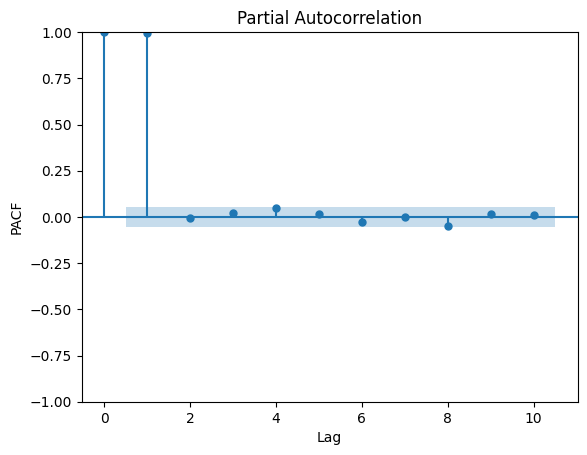

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Dữ liệu chuỗi thời gian
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Vẽ đồ thị PACF
plot_pacf(df, lags=10)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
14/14 [==============================] - 12s 185ms/step - loss: 0.1879 - val_loss: 0.4059
Epoch 2/50
14/14 [==============================] - 0s 13ms/step - loss: 0.1329 - val_loss: 0.2674
Epoch 3/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0634 - val_loss: 0.0794
Epoch 4/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0315 - val_loss: 0.0191
Epoch 5/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0264 - val_loss: 0.0419
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 7/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0147 - val_loss: 0.0108
Epoch 8/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0044
Epoch 9/50
14/14 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 10/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


4/4 [==============================] - 0s 5ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)


In [13]:
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)

In [14]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 8784.74350625773
Testing RMSE: 7981.22477911198
Validation MAPE: 8.029272664089735
Testing MAPE: 8.051630033420153
Validation MAE: 6815.8138775406505
Testing MAE: 6289.612658765039


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[len(val_data)-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
lst_output=scaler.inverse_transform(lst_output)
print(lst_output)

[0.97335297]
2
1 day input [0.97335297]
1 day output [[0.978132]]
2 day input [0.97813201]
2 day output [[0.9828553]]
3 day input [0.98285532]
3 day output [[0.9875197]]
4 day input [0.98751968]
4 day output [[0.99212146]]
5 day input [0.99212146]
5 day output [[0.9966581]]
6 day input [0.99665809]
6 day output [[1.0011262]]
7 day input [1.00112617]
7 day output [[1.0055236]]
8 day input [1.00552356]
8 day output [[1.0098476]]
9 day input [1.00984764]
9 day output [[1.0140959]]
10 day input [1.0140959]
10 day output [[1.0182666]]
11 day input [1.01826656]
11 day output [[1.0223576]]
12 day input [1.02235758]
12 day output [[1.0263673]]
13 day input [1.02636731]
13 day output [[1.030294]]
14 day input [1.03029394]
14 day output [[1.0341362]]
15 day input [1.03413618]
15 day output [[1.0378932]]
16 day input [1.03789318]
16 day output [[1.041564]]
17 day input [1.04156399]
17 day output [[1.0451474]]
18 day input [1.04514742]
18 day output [[1.0486432]]
19 day input [1.04864323]
19 day o

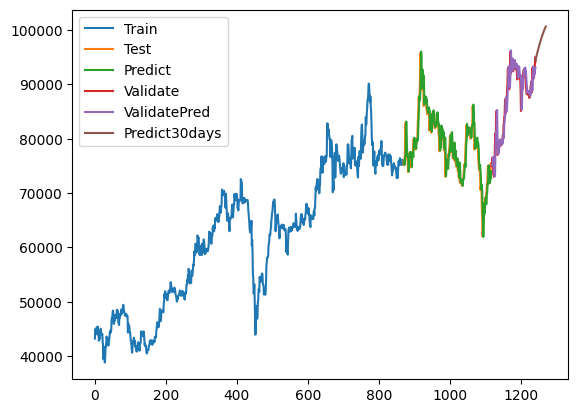

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,lst_output)

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()